## IMPORT DATA

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/data_exist.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nomor_rekening                    451 non-null    int64  
 1   Nama Debitur                      451 non-null    object 
 2   nomor_registrasi                  451 non-null    int64  
 3   kode_kantor                       451 non-null    object 
 4   tanggal_pinjaman                  451 non-null    object 
 5   kualitas_kredit                   451 non-null    object 
 6   usia                              451 non-null    int64  
 7   jenis_kelamin                     451 non-null    object 
 8   status_perkawinan                 451 non-null    object 
 9   alamat_kota                       451 non-null    object 
 10  gaji(Penghasilan)                 451 non-null    object 
 11  jenis_pinjaman                    451 non-null    object 
 12  plafon  

## PREPROCESSING

In [81]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

##### Drop Column

In [84]:
drop_cols = ['nomor_rekening', 'Nama Debitur', 'kode_kantor', 'tanggal_pinjaman', 'Nilai Pefindo', 'Persentasi gagal bayar Pefindo', 'nilai_collateral_coverage_market', 'nilai_LTV_Market']
df = df.drop(drop_cols, axis=1)

##### Data Cleaning

In [87]:
# usia 0
df.loc[df['usia'] == 0, 'usia'] = df.loc[df['usia'] > 0, 'usia'].median()

# plafon
df['plafon'] = df['plafon'].str.replace('Rp', '', regex=True)
df['plafon'] = df['plafon'].str.replace(r'(?<=\d)\.(?=\d)', '', regex=True)
df['plafon'] = df['plafon'].str.replace(r'(?<=\d),(?=\d)', '', regex=True)
df['plafon'] = df['plafon'].astype(float)
df['plafon'] = df.apply(lambda row: row['plafon'] / 10, axis=1)

# jenis_jaminan NaN
df.loc[df['jenis_jaminan'].isna(), 'jenis_jaminan'] = 'Lainnya'

# sandi_pengikatan NaN
df.loc[df['sandi_pengikatan'].isna(), 'sandi_pengikatan'] = 'Lainnya'

# jumlah_tanggungan NaN
df.loc[df['jumlah_tanggungan'].isna(), 'jumlah_tanggungan'] = df.loc[df['jumlah_tanggungan'] > 0, 'jumlah_tanggungan'].median()

# pendidikan NaN
df.loc[df['pendidikan'].isna(), 'pendidikan'] = 'SD-SMA'

# jenis_usaha NaN
df.loc[df['jenis_usaha'].isna(), 'jenis_usaha'] = 'Lainnya'

# Nilai Pasar Agunan
df['Nilai Pasar Agunan'] = df['Nilai Pasar Agunan'].str.replace('Rp', '', regex=True)
df['Nilai Pasar Agunan'] = df['Nilai Pasar Agunan'].str.replace(r'(?<=\d)\.(?=\d)', '', regex=True)
df.loc[df['Nilai Pasar Agunan'].isin(['-', 'IJAZAH', 'Ijazah', 'Tanpa agunan']), 'Nilai Pasar Agunan'] = 0.01
df['Nilai Pasar Agunan'] = df['Nilai Pasar Agunan'].astype(float)
df.loc[df['Nilai Pasar Agunan'].isna(), 'Nilai Pasar Agunan'] = df['Nilai Pasar Agunan'].median(skipna=True)

# LTV & Collateral Coverage
df['LTV'] = df.apply(lambda row: row['plafon'] / row['Nilai Pasar Agunan'], axis=1)

# Collateral Coverage
df['Collateral Coverage'] = df.apply(lambda row: row['Nilai Pasar Agunan'] / row['plafon'], axis=1)

# Lama Menikah
df.loc[~df['Lama Menikah'].isin(['Cerai', 'Cerai Hidup', 'Cerai Mati']), 'Lama Menikah'] = pd.cut(
    df.loc[~df['Lama Menikah'].isin(['Cerai', 'Cerai Hidup', 'Cerai Mati']), 'Lama Menikah'].astype(float), 
    bins=[0, 1, 11, 31, float('inf')], labels=['Belum Menikah', '1-10 Tahun', '11-30 Tahun', 'Lebih 30 Tahun'], right=False
)
df.loc[df['Lama Menikah'].isna(), 'Lama Menikah'] = 'Tidak Diketahui'

# Riwayat SLIK
df.loc[df['Riwayat Slik'].isna(), 'Riwayat Slik'] = 'Tidak ditemukan riwayat SLIK'

# Penilaian Rekening Koran
df.loc[df['Penilaian Rekening Koran'].isna(), 'Penilaian Rekening Koran'] = 'Debitur tidak memiliki rekening koran, Tidak dilakukan pengecekan fineksi/ tidak ada rekapan rekening koran'

# DBR
df['DBR'] = df['DBR'].str.replace('%', '').str.replace(',', '.').astype(float)
df.loc[df['DBR'].isna(), 'DBR'] = df['DBR'].median()

##### Duplicates Data

In [90]:
print('Ada data duplikat' if df.duplicated().any() else 'Tidak ada data duplikat')

Tidak ada data duplikat


##### Data Type

In [93]:
numerical_cols = [['usia', 'tenor', 'jumlah_Pengajuan', 'jumlah_tanggungan'], ['plafon', 'Nilai Pasar Agunan', 'LTV', 'Collateral Coverage', 'DBR']]
categorical_cols = ['nomor_registrasi', 'kualitas_kredit', 'jenis_kelamin', 'status_perkawinan', 'alamat_kota', 'gaji(Penghasilan)', 
                    'jenis_pinjaman', 'tujuan_penggunaan', 'jenis_jaminan', 'sandi_pengikatan', 'Restruktur', 'jenis_pekerjaan', 'pendidikan', 
                    'jenis_usaha', 'Lama Menikah', 'Riwayat Slik', 'Penilaian Rekening Koran']

for n in numerical_cols[0]:
    df[n] = df[n].astype(int)

for n in numerical_cols[1]:
    df[n] = df[n].astype(float)

for c in categorical_cols:
    df[c] = df[c].astype(str)

##### Data Encoding

In [96]:
for c in categorical_cols:
    print(f'{c}: {df[c].nunique()}')

nomor_registrasi: 423
kualitas_kredit: 5
jenis_kelamin: 2
status_perkawinan: 5
alamat_kota: 27
gaji(Penghasilan): 6
jenis_pinjaman: 16
tujuan_penggunaan: 3
jenis_jaminan: 8
sandi_pengikatan: 6
Restruktur: 2
jenis_pekerjaan: 254
pendidikan: 6
jenis_usaha: 7
Lama Menikah: 8
Riwayat Slik: 6
Penilaian Rekening Koran: 10


In [35]:
for c in [item for item in categorical_cols if item not in ['nomor_registrasi', 'jenis_pekerjaan']]:
    print(f'{c}: {df[c].unique()}')

kualitas_kredit: ['Macet' 'Lancar' 'Tidak Lancar' 'Diragukan' 'Dalam Perhatian Khusus']
jenis_kelamin: ['Pria' 'Wanita']
status_perkawinan: ['BELUM MENIKAH' 'MENIKAH' 'CERAI' 'CERAI HIDUP' 'CERAI MATI']
alamat_kota: ['Kota Depok' 'Kota Jakarta Timur' 'Kota Bogor' 'Kab Bogor'
 'Kota Jakarta Selatan' 'Kota Tangerang' 'Kota Bekasi' 'Kab Subang'
 'Kab Lebak' 'Kota Jakarta Utara' 'Kab Kuningan' 'Kab Bekasi'
 'Kota Jakarta Barat' 'Kab Ngawi' 'Kota Tangerang Selatan' 'Kab Grobogan'
 'Kab Sidoarjo' 'Kota Cilegon' 'Kota Bandung' 'Kota Jakarta Pusat'
 'Kab Tangerang' 'Kota Sukabumi' 'Kota Surabaya' 'Kab Karawang'
 'Kab Sukabumi' 'Kab Pekalongan' 'Kab Garut']
gaji(Penghasilan): ['0 S/D 5.000.000' '> 10,000,000 S/D 25,000,000'
 '> 5,000,000 S/D 7,500,000' '> 50,000,000' '> 25,000,000 S/D 50,000,000'
 '> 7,500,000 S/D 10,000,000']
jenis_pinjaman: ['KREDIT KONSUMTIF - KREDIT ANEKA GUNA'
 'KREDIT KONSUMTIF - KREDIT ANEKA GUNA BERJANGKA' 'KMK - LAINNYA'
 'KMK BERJANGKA - LAINNYA'
 'KREDIT KONSUMTIF - 

In [98]:
# New DataFrame
data = pd.DataFrame()

# Label Encoding
le = {}
for c in [item for item in categorical_cols if item not in ['kualitas_kredit', 'gaji(Penghasilan)', 'pendidikan']]:
    le[c] = LabelEncoder()
    data[c] = le[c].fit_transform(df[c])

data['kualitas_kredit'] = df['kualitas_kredit'].map({
    'Lancar': 1,
    'Dalam Perhatian Khusus': 2,
    'Tidak Lancar': 3,
    'Diragukan': 4,
    'Macet': 5
})
data['gaji(Penghasilan)'] = df['gaji(Penghasilan)'].map({
    '0 S/D 5.000.000': 1,
    '> 5,000,000 S/D 7,500,000': 2,
    '> 7,500,000 S/D 10,000,000': 3,
    '> 10,000,000 S/D 25,000,000': 4,
    '> 25,000,000 S/D 50,000,000': 5,
    '> 50,000,000': 6
})
data['pendidikan'] = df['pendidikan'].map({
    'Tidak Bersekolah': 0,
    'SD-SMA': 1,
    'Diploma 1 - 3': 2,
    'S-1': 3,
    'S-2': 4,
    'S-3': 5
})

In [100]:
numerical_col = [item for items in numerical_cols for item in items]
data = pd.concat([data, df[numerical_col]], axis=1)
data

,nomor_registrasi,jenis_kelamin,status_perkawinan,alamat_kota,jenis_pinjaman,tujuan_penggunaan,jenis_jaminan,sandi_pengikatan,Restruktur,jenis_pekerjaan,...,pendidikan,usia,tenor,jumlah_Pengajuan,jumlah_tanggungan,plafon,Nilai Pasar Agunan,LTV,Collateral Coverage,DBR
0,26,0,0,17,13,1,5,2,1,4,...,1,26,60,1,1,90000000.0,3.693000e+08,2.437043e-01,4.103333e+00,65.02
1,38,0,4,17,13,1,5,2,0,34,...,1,42,36,1,2,40000000.0,3.080000e+08,1.298701e-01,7.700000e+00,44.56
2,408,0,4,21,13,1,5,2,1,186,...,1,44,60,1,5,30000000.0,3.595680e+08,8.343345e-02,1.198560e+01,28.20
3,5,0,4,15,13,1,3,3,0,200,...,1,36,36,1,2,15000000.0,1.000000e-02,1.500000e+09,6.666667e-10,37.36
4,35,0,4,1,13,1,5,2,1,70,...,1,45,60,1,3,110000000.0,2.410000e+08,4.564315e-01,2.190909e+00,59.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,34,1,4,17,6,2,2,1,0,218,...,1,42,36,1,3,60000000.0,1.320000e+08,4.545455e-01,2.200000e+00,54.43
447,380,1,4,17,4,2,5,2,0,70,...,1,45,36,1,2,40000000.0,1.914840e+08,2.088947e-01,4.787100e+00,29.44
448,385,1,3,17,14,1,5,2,0,70,...,1,48,36,1,2,30000000.0,1.851660e+08,1.620168e-01,6.172200e+00,33.41
449,234,1,4,17,14,1,2,1,0,33,...,3,29,84,2,0,330000000.0,1.828500e+09,1.804758e-01,5.540909e+00,63.45


## Feature Engineering

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

##### Correlation

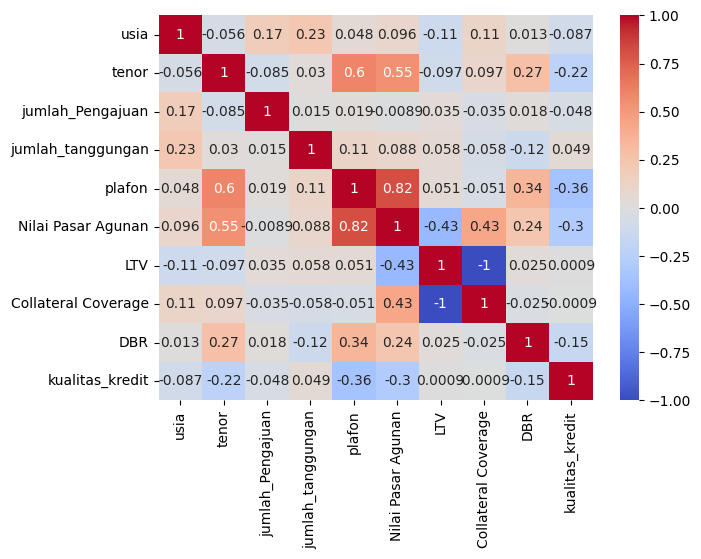

In [63]:
plt.figure(figsize=(7, 5))
sns.heatmap(data[numerical_col + ['kualitas_kredit']].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.show()

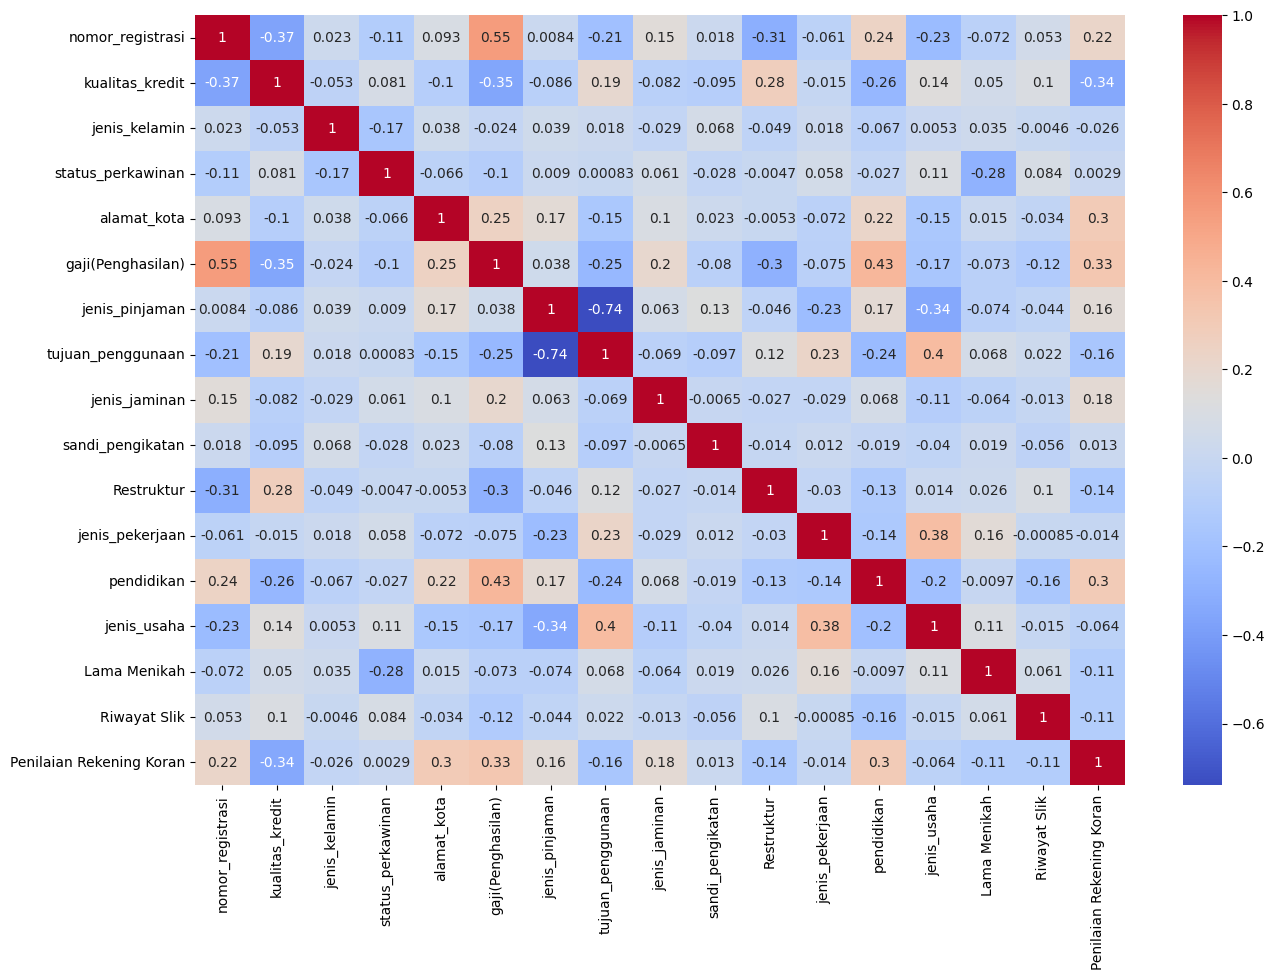

In [24]:
plt.figure(figsize=(15, 10))
sns.heatmap(data[categorical_cols].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.show()

##### ANOVA

In [26]:
X = data[categorical_cols].drop(['kualitas_kredit', 'nomor_registrasi'], axis=1)
y = data['kualitas_kredit']
f_scores, p_values = f_classif(X, y)

anova = pd.DataFrame({
    'Feature': X.columns, 
    'F-Score': f_scores, 
    'P-Value': p_values
})
anova = anova.sort_values(by='F-Score', ascending=False)
anova['F-Score'] = anova['F-Score'].apply(lambda x: f'{x:.3f}')
anova['P-Value'] = anova['P-Value'].apply(lambda x: f'{x:.3f}')
anova

,Feature,F-Score,P-Value
3,gaji(Penghasilan),13.398,0.000
14,Penilaian Rekening Koran,13.065,0.000
8,Restruktur,9.403,0.000
10,pendidikan,8.755,0.000
13,Riwayat Slik,7.520,0.000
6,jenis_jaminan,5.724,0.000
5,tujuan_penggunaan,4.884,0.001
11,jenis_usaha,3.374,0.010
4,jenis_pinjaman,3.035,0.017
2,alamat_kota,2.753,0.028


##### Chi2

In [28]:
X = data[categorical_cols].drop(['kualitas_kredit', 'nomor_registrasi'], axis=1)
y = data['kualitas_kredit']
chi_scores, p_values = chi2(X, y)

chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi-Score': chi_scores,
    'P-Value': p_values
})
chi2_results = chi2_results.sort_values(by='Chi-Score', ascending=False)
chi2_results['Chi-Score'] = chi2_results['Chi-Score'].apply(lambda x: f'{x:.3f}')
chi2_results['P-Value'] = chi2_results['P-Value'].apply(lambda x: f'{x:.3f}')
chi2_results

,Feature,Chi-Score,P-Value
9,jenis_pekerjaan,192.081,0.000
14,Penilaian Rekening Koran,128.395,0.000
2,alamat_kota,74.563,0.000
3,gaji(Penghasilan),45.774,0.000
11,jenis_usaha,35.476,0.000
4,jenis_pinjaman,32.807,0.000
8,Restruktur,30.488,0.000
13,Riwayat Slik,24.806,0.000
12,Lama Menikah,21.614,0.000
10,pendidikan,19.750,0.001


##### Mutual Gain

In [146]:
X = data[numerical_col]
y = data['kualitas_kredit']
mutual_info = mutual_info_classif(X, y)

mutual_info = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Gain': mutual_info
})
mutual_info = mutual_info.sort_values(by='Mutual Gain', ascending=False)
mutual_info

,Feature,Mutual Gain
5,Nilai Pasar Agunan,0.148089
8,DBR,0.125063
4,plafon,0.123015
7,Collateral Coverage,0.076425
1,tenor,0.050701
0,usia,0.027327
6,LTV,0.014041
3,jumlah_tanggungan,0.001475
2,jumlah_Pengajuan,0.000000


In [148]:
X = data[categorical_cols].drop(['kualitas_kredit', 'nomor_registrasi'], axis=1)
y = data['kualitas_kredit']
mutual_info = mutual_info_classif(X, y)

mutual_info = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Gain': mutual_info
})
mutual_info = mutual_info.sort_values(by='Mutual Gain', ascending=False)
mutual_info

,Feature,Mutual Gain
4,jenis_pinjaman,0.100716
2,alamat_kota,0.096306
14,Penilaian Rekening Koran,0.075312
5,tujuan_penggunaan,0.045857
3,gaji(Penghasilan),0.044284
10,pendidikan,0.041327
7,sandi_pengikatan,0.040336
13,Riwayat Slik,0.037693
11,jenis_usaha,0.030675
8,Restruktur,0.030380


## Model

In [219]:
import pandas as pd
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Collection

In [11]:
numerical_cols = ['Nilai Pasar Agunan', 'DBR', 'plafon', 'Collateral Coverage', 'tenor', 'usia']
categorical_cols = [
    # 'jenis_pekerjaan', 'Penilaian Rekening Koran', 'alamat_kota', 
    # 'gaji(Penghasilan)', 'jenis_usaha', 'jenis_pinjaman',
    # 'Restruktur', 'Riwayat Slik', 'Lama Menikah', 'pendidikan', 'jenis_jaminan',
    'jenis_pinjaman', 'alamat_kota', 'Penilaian Rekening Koran',
    'tujuan_penggunaan', 'gaji(Penghasilan)', 'pendidikan',
    'sandi_pengikatan', 'Riwayat Slik', 'jenis_usaha', 'Restruktur'
]

df = pd.read_csv('./data/data_exist_cleaned.csv')
df = df[numerical_cols + categorical_cols + ['kualitas_kredit']]
df

,Nilai Pasar Agunan,DBR,plafon,Collateral Coverage,tenor,usia,jenis_pinjaman,alamat_kota,Penilaian Rekening Koran,tujuan_penggunaan,gaji(Penghasilan),pendidikan,sandi_pengikatan,Riwayat Slik,jenis_usaha,Restruktur,kualitas_kredit
0,3.693000e+08,65.02,90000000.0,4.103333e+00,60,26,13,17,2,1,1,1,2,3,0,1,5
1,3.080000e+08,44.56,40000000.0,7.700000e+00,36,42,13,17,2,1,1,1,2,0,0,0,5
2,3.595680e+08,28.20,30000000.0,1.198560e+01,60,44,13,21,2,1,1,1,2,1,0,1,5
3,1.000000e-02,37.36,15000000.0,6.666667e-10,36,36,13,15,2,1,1,1,3,0,0,0,5
4,2.410000e+08,59.51,110000000.0,2.190909e+00,60,45,13,1,2,1,1,1,2,1,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,1.320000e+08,54.43,60000000.0,2.200000e+00,36,42,6,17,9,2,1,1,1,2,3,0,1
447,1.914840e+08,29.44,40000000.0,4.787100e+00,36,45,4,17,0,2,1,1,2,1,0,0,1
448,1.851660e+08,33.41,30000000.0,6.172200e+00,36,48,14,17,0,1,1,1,2,2,0,0,1
449,1.828500e+09,63.45,330000000.0,5.540909e+00,84,29,14,17,8,1,3,3,1,2,3,0,1


#### Target Clustering

In [9]:
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [239]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

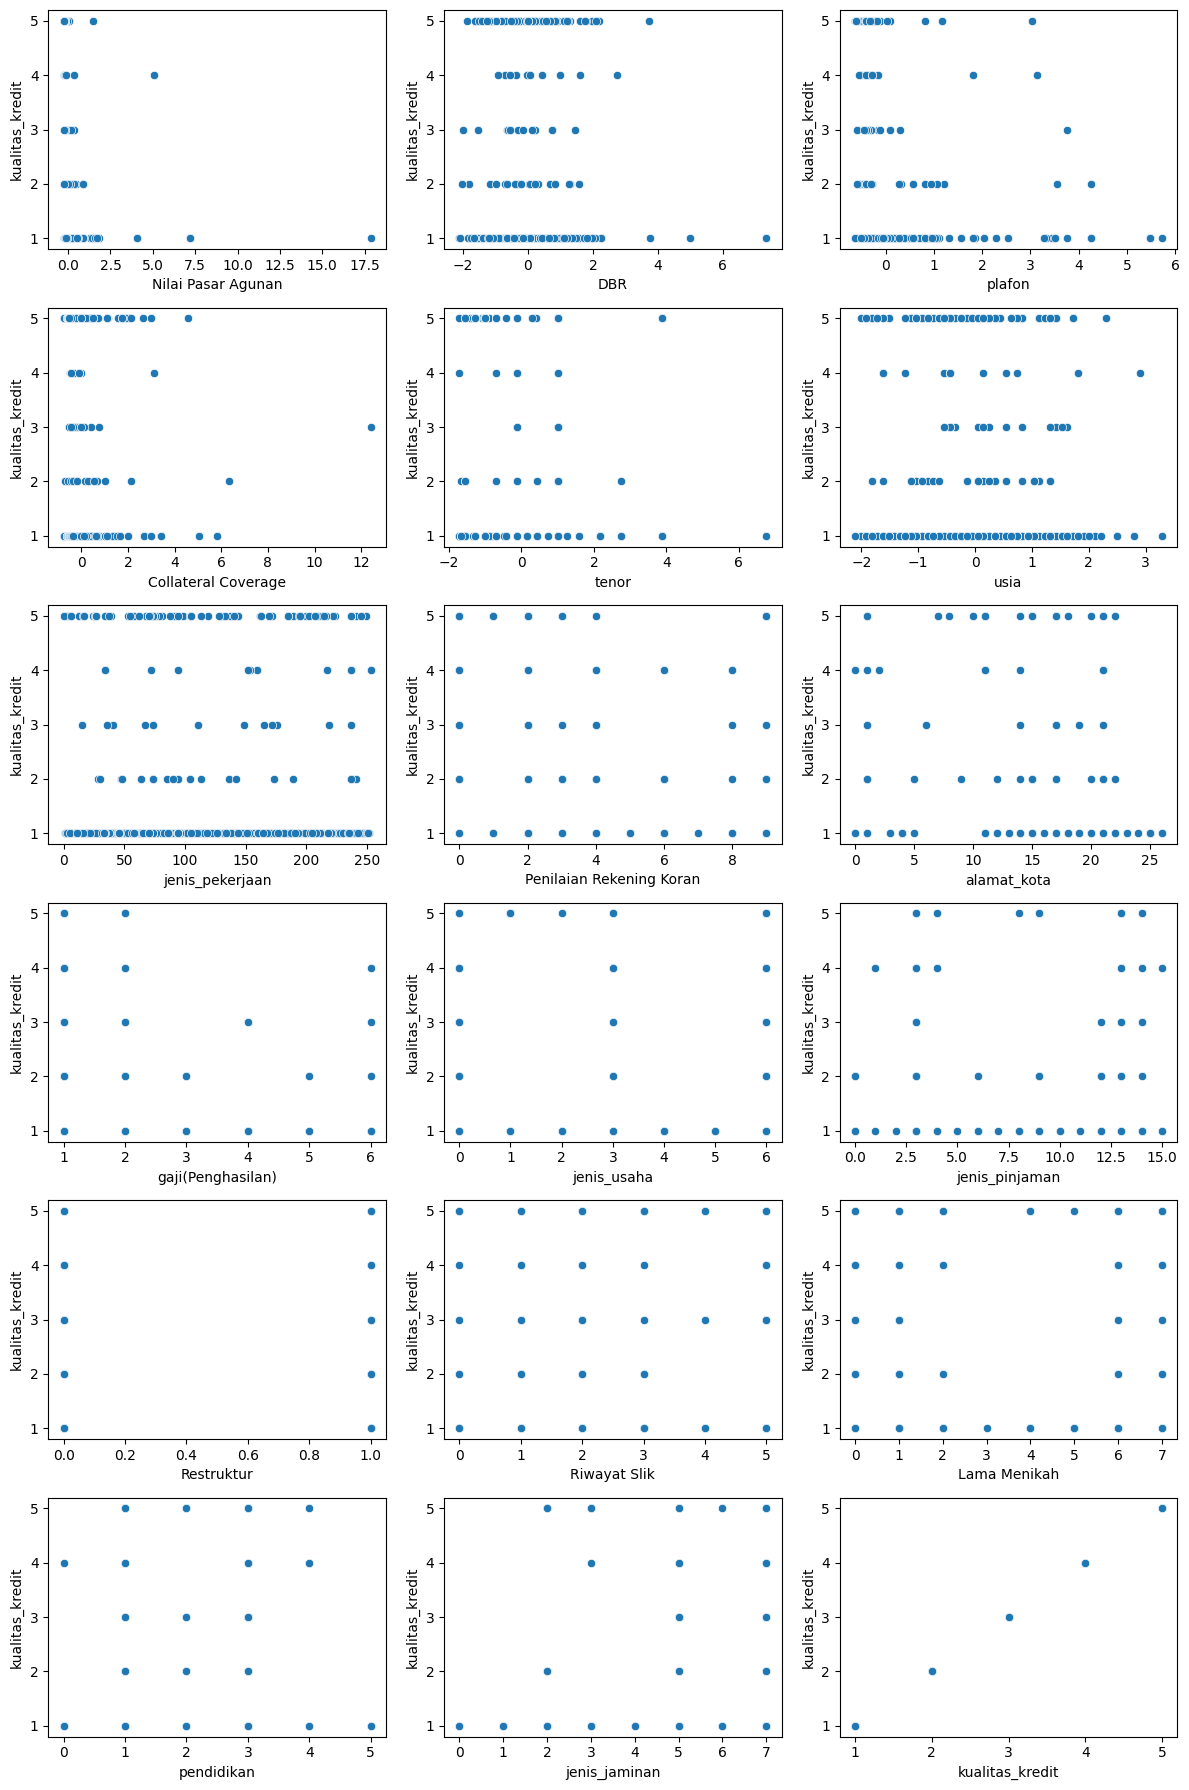

In [273]:
plt.figure(figsize=(12, 18))

for i, feature in enumerate(feature_selected, 1):
    plt.subplot(6, 3, i)
    sns.scatterplot(data=df, x=feature, y='kualitas_kredit')

plt.tight_layout()
plt.show()

With UMAP feature reduction

In [13]:
umap_reducer = umap.UMAP(n_components=2)
X_umap = umap_reducer.fit_transform(df.drop('kualitas_kredit', axis=1))

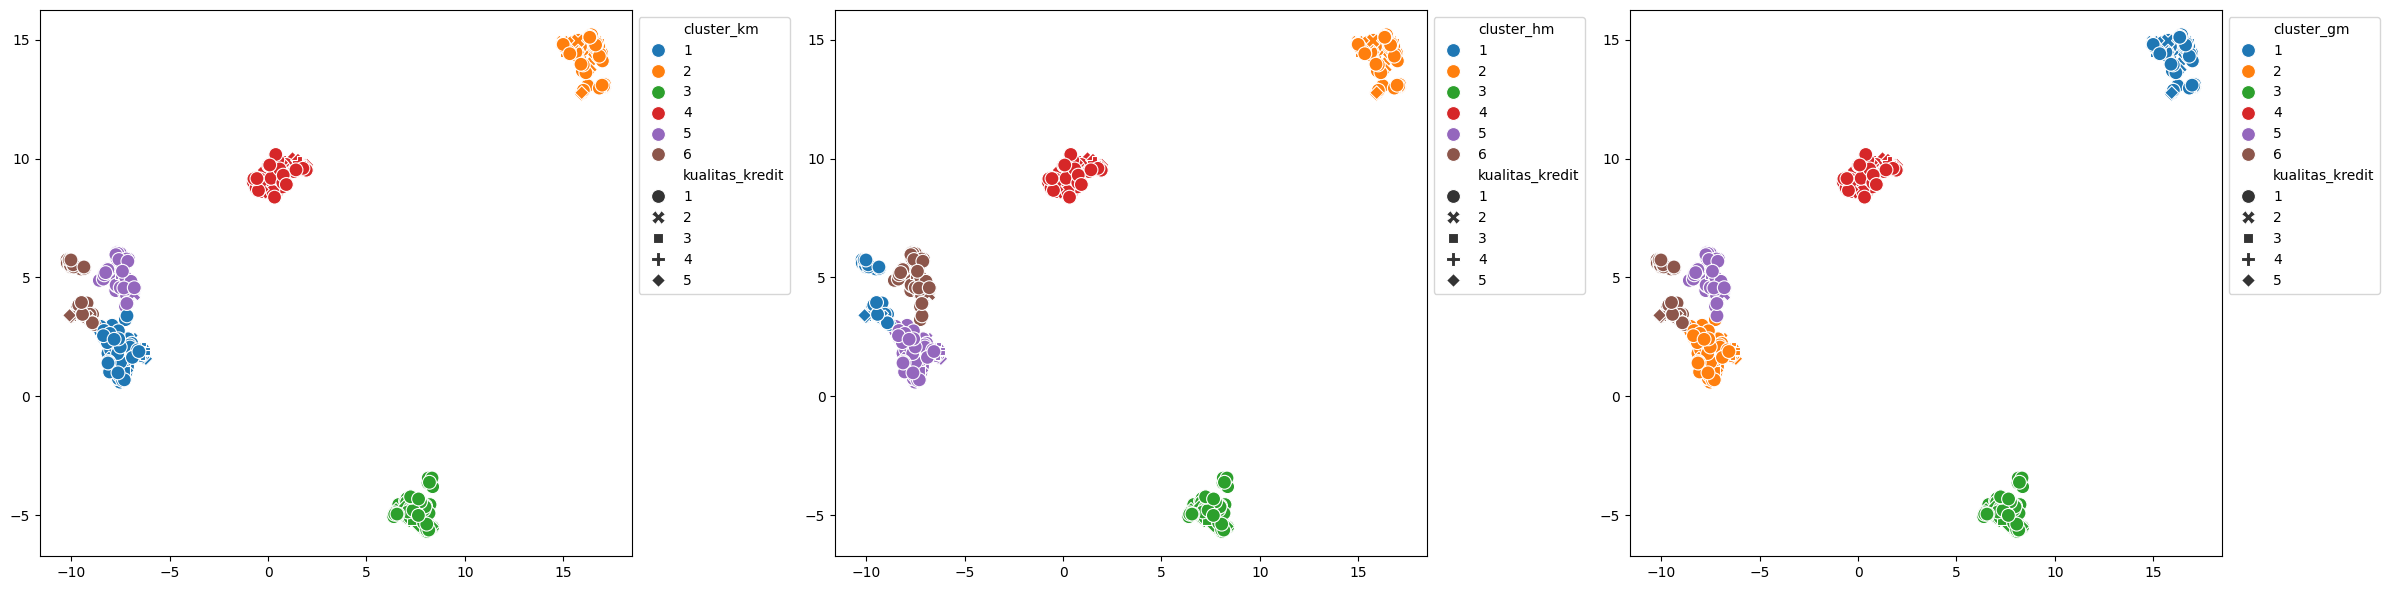

In [14]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
hm = AgglomerativeClustering(n_clusters=6)
gmm = GaussianMixture(n_components=6)

df['cluster_km'] = kmeans.fit_predict(X_umap) + 1
df['cluster_hm'] = hm.fit_predict(X_umap) + 1
df['cluster_gm'] = gmm.fit_predict(X_umap) + 1

plt.figure(figsize=(24, 6))
for i, cluster in enumerate(['cluster_km', 'cluster_hm', 'cluster_gm'], 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df[cluster], style=df['kualitas_kredit'], palette='tab10', s=100)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

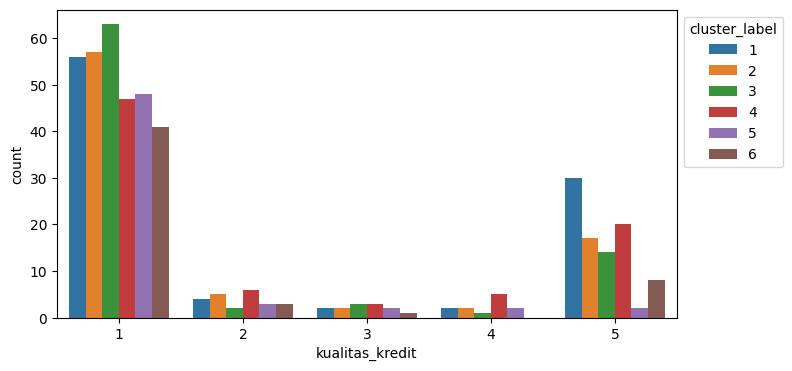

In [17]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='kualitas_kredit', hue='cluster_gm', palette='tab10')

plt.legend(title='cluster_label', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Without feature reduction

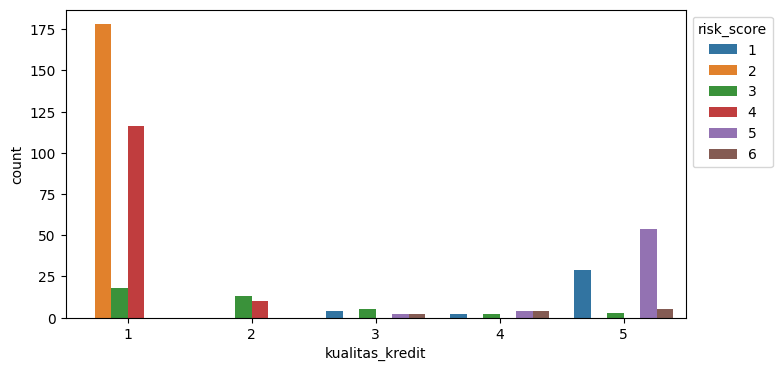

In [249]:
kmeans = KMeans(n_clusters=6, random_state=42)
hm = AgglomerativeClustering(n_clusters=6)
gmm = GaussianMixture(n_components=6, random_state=42)

feature = ['Nilai Pasar Agunan', 'DBR', 'plafon',
           'Collateral Coverage', 'tenor', 'usia',
           # 'jenis_pinjaman',
           # 'alamat_kota',
           'Penilaian Rekening Koran',
           # 'tujuan_penggunaan',
           'gaji(Penghasilan)', 
           # 'pendidikan',
           # 'sandi_pengikatan', 
           'Riwayat Slik', 
           # 'jenis_usaha', 
           # 'Restruktur',
           'kualitas_kredit']
df['risk_score'] = gmm.fit_predict(df[feature]) + 1

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='kualitas_kredit', hue='risk_score', palette='tab10')

plt.legend(title='risk_score', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [251]:
pd.crosstab(df['risk_score'], df['kualitas_kredit'])

kualitas_kredit,1,2,3,4,5
risk_score,,,,,
1,0,0,4,2,29
2,178,0,0,0,0
3,18,13,5,2,3
4,116,10,0,0,0
5,0,0,2,4,54
6,0,0,2,4,5


In [253]:
df['risk_score'] = df['risk_score'].map({
    1: 5,
    2: 1,
    3: 3,
    4: 2,
    5: 6,
    6: 4
})

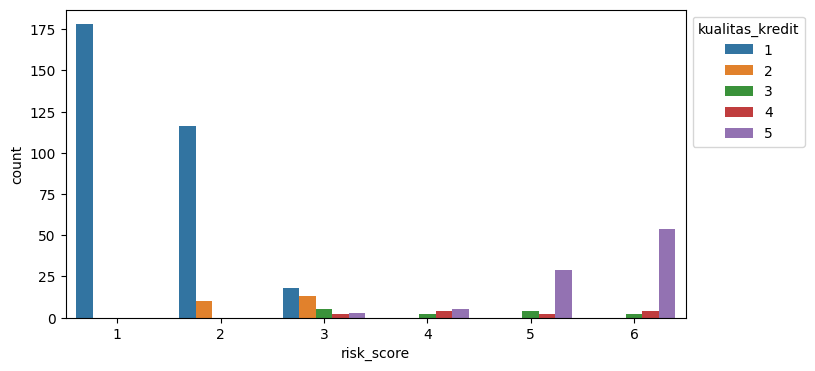

In [255]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='risk_score', hue='kualitas_kredit', palette='tab10')

plt.legend(title='kualitas_kredit', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

#### Target Distribution

In [31]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler

In [247]:
numerical_cols = ['Nilai Pasar Agunan', 'DBR', 'plafon', 'Collateral Coverage', 'tenor', 'usia']
categorical_cols = [
    # 'jenis_pekerjaan', 'Penilaian Rekening Koran', 'alamat_kota', 
    # 'gaji(Penghasilan)', 'jenis_usaha', 'jenis_pinjaman',
    # 'Restruktur', 'Riwayat Slik', 'Lama Menikah', 'pendidikan', 'jenis_jaminan',
    'jenis_pinjaman', 'alamat_kota', 'Penilaian Rekening Koran',
    'tujuan_penggunaan', 'gaji(Penghasilan)', 'pendidikan',
    'sandi_pengikatan', 'Riwayat Slik', 'jenis_usaha', 'Restruktur'
]

df = pd.read_csv('./data/data_exist_labeled.csv')
df = df.drop('kualitas_kredit', axis=1)

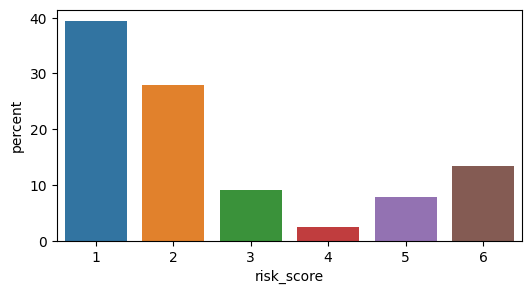

In [251]:
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='risk_score', stat='percent', hue='risk_score', palette=sns.color_palette(n_colors=6), legend=False)
plt.show()

Random Oversampling

In [254]:
oversampler = RandomOverSampler(random_state=42)
X_rand, y_rand = oversampler.fit_resample(df.drop('risk_score', axis=1), df['risk_score'])

df_rand = pd.DataFrame(X_rand, columns=df.drop('risk_score', axis=1).columns)
df_rand['risk_score'] = y_rand

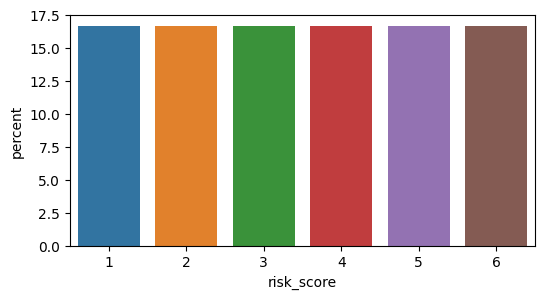

In [256]:
plt.figure(figsize=(6, 3))
sns.countplot(data=df_rand, x='risk_score', stat='percent', hue='risk_score', palette=sns.color_palette(n_colors=6), legend=False)
plt.show()

SMOTE-NC

In [259]:
categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_smote, y_smote = smote_nc.fit_resample(df.drop('risk_score', axis=1), df['risk_score'])

df_smote = pd.DataFrame(X_smote, columns=df.drop('risk_score', axis=1).columns)
df_smote['risk_score'] = y_smote

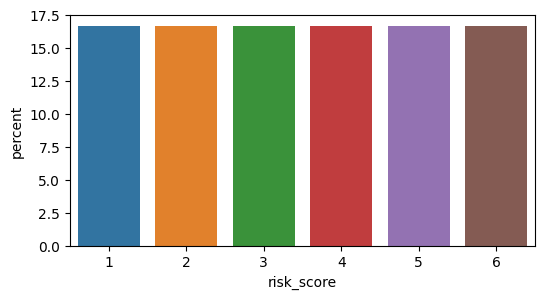

In [261]:
plt.figure(figsize=(6, 3))
sns.countplot(data=df_smote, x='risk_score', stat='percent', hue='risk_score', palette=sns.color_palette(n_colors=6), legend=False)
plt.show()

#### Classifier

In [264]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [266]:
def model_summary(model, data_test, data_pred):
    print(classification_report(data_pred, data_test, digits=6, zero_division=np.nan))
    
    cMatrix = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(data_test, data_pred), display_labels=['1', '2', '3', '4', '5', '6'])
    cMatrix.plot(cmap='Blues')
    plt.plot()
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')

Data Splitting

In [269]:
X = df.drop('risk_score', axis=1)
y = df['risk_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_rand = df_rand.drop('risk_score', axis=1)
y_rand = df_rand['risk_score']
X_rand_train, X_rand_test, y_rand_train, y_rand_test = train_test_split(X_rand, y_rand, test_size=0.2, random_state=42, stratify=y_rand)

X_smote = df_smote.drop('risk_score', axis=1)
y_smote = df_smote['risk_score']
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

Feature Scaling

In [272]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_rand_train_scaled = scaler.fit_transform(X_rand_train)
X_rand_test_scaled = scaler.transform(X_rand_test)

X_smote_train_scaled = scaler.fit_transform(X_smote_train)
X_smote_test_scaled = scaler.transform(X_smote_test)

Cross Validation

In [276]:
cv_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

KNN

Cross-Validation mean: 0.6458850747977104
Cross-Validation std: 0.052612765140457506 

              precision    recall  f1-score   support

           1   0.944444  0.790698  0.860759        43
           2   0.730769  0.655172  0.690909        29
           3   0.500000  1.000000  0.666667         4
           4   0.000000       nan  0.000000         0
           5   1.000000  1.000000  1.000000         7
           6   0.416667  0.625000  0.500000         8

    accuracy                       0.758242        91
   macro avg   0.598647  0.814174  0.619723        91
weighted avg   0.814690  0.758242  0.777095        91



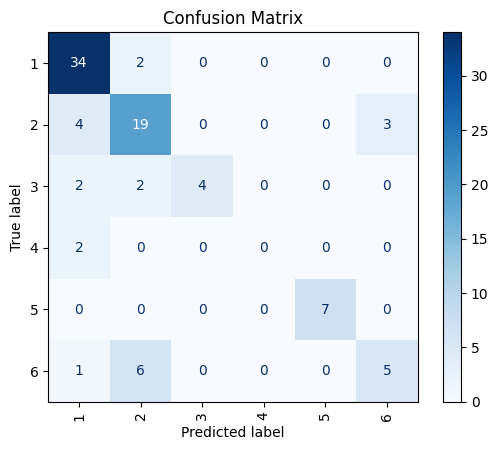

In [279]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)

cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(knn, y_test, knn_pred)

Cross-Validation mean: 0.7437265748283457
Cross-Validation std: 0.032693485798535905 

              precision    recall  f1-score   support

           1   0.657143  0.821429  0.730159        28
           2   0.571429  0.714286  0.634921        28
           3   0.861111  0.815789  0.837838        38
           4   1.000000  0.857143  0.923077        42
           5   1.000000  0.923077  0.960000        39
           6   0.805556  0.743590  0.773333        39

    accuracy                       0.817757       214
   macro avg   0.815873  0.812552  0.809888       214
weighted avg   0.838967  0.817757  0.824436       214



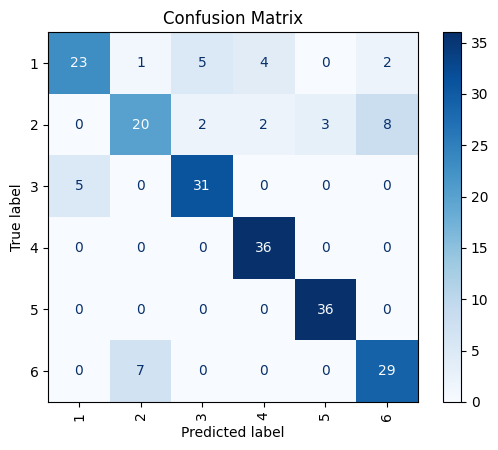

In [281]:
knn_rand = KNeighborsClassifier()
knn_rand.fit(X_rand_train_scaled, y_rand_train)
knn_rand_pred = knn_rand.predict(X_rand_test_scaled)

cv_scores = cross_val_score(knn_rand, X_rand_train_scaled, y_rand_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(knn_rand, y_rand_test, knn_rand_pred)

Cross-Validation mean: 0.7255787437130922
Cross-Validation std: 0.022787150865624568 

              precision    recall  f1-score   support

           1   0.742857  0.928571  0.825397        28
           2   0.657143  0.575000  0.613333        40
           3   0.888889  0.842105  0.864865        38
           4   0.888889  0.842105  0.864865        38
           5   0.888889  0.914286  0.901408        35
           6   0.777778  0.800000  0.788732        35

    accuracy                       0.808411       214
   macro avg   0.807407  0.817011  0.809767       214
weighted avg   0.808293  0.808411  0.806211       214



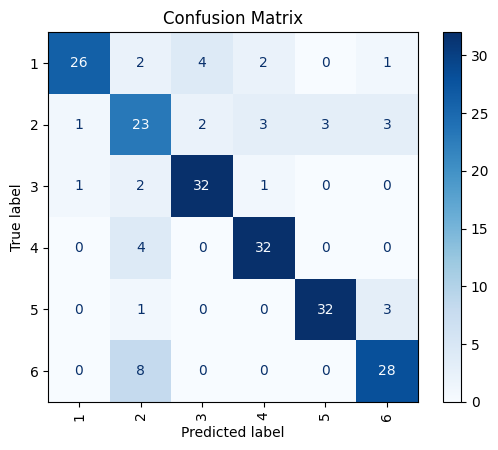

In [283]:
knn_smote = KNeighborsClassifier()
knn_smote.fit(X_smote_train_scaled, y_smote_train)
knn_smote_pred = knn_smote.predict(X_smote_test_scaled)

cv_scores = cross_val_score(knn_smote, X_smote_train_scaled, y_smote_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(knn_smote, y_smote_test, knn_smote_pred)

Naive Bayes

Cross-Validation mean: 0.6723053823048799
Cross-Validation std: 0.0555494580874847 

              precision    recall  f1-score   support

           1   0.750000  0.964286  0.843750        28
           2   0.807692  0.583333  0.677419        36
           3   0.750000  0.666667  0.705882         9
           4   0.000000  0.000000  0.000000         1
           5   1.000000  0.777778  0.875000         9
           6   0.250000  0.375000  0.300000         8

    accuracy                       0.703297        91
   macro avg   0.592949  0.561177  0.567009        91
weighted avg   0.745351  0.703297  0.710330        91



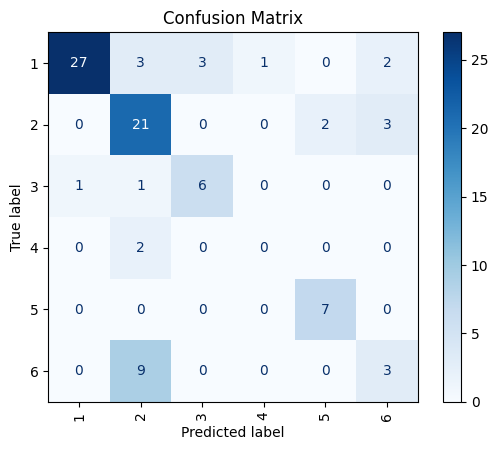

In [285]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
nb_pred = nb.predict(X_test_scaled)

cv_scores = cross_val_score(nb, X_train_scaled, y_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(nb, y_test, nb_pred)

Cross-Validation mean: 0.6629754044058105
Cross-Validation std: 0.03709499541836557 

              precision    recall  f1-score   support

           1   0.685714  0.800000  0.738462        30
           2   0.771429  0.415385  0.540000        65
           3   0.722222  0.764706  0.742857        34
           4   0.472222  0.894737  0.618182        19
           5   1.000000  0.878049  0.935065        41
           6   0.500000  0.720000  0.590164        25

    accuracy                       0.691589       214
   macro avg   0.691931  0.745479  0.694122       214
weighted avg   0.737112  0.691589  0.688543       214



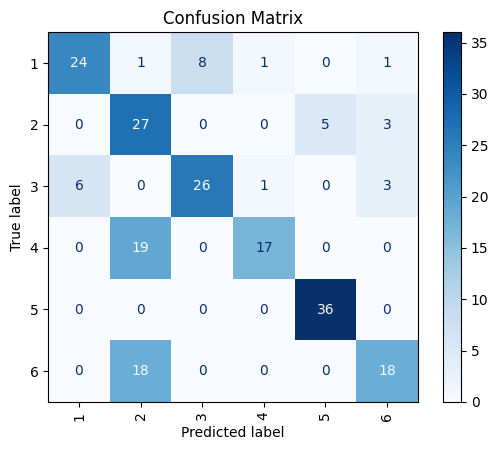

In [287]:
nb_rand = GaussianNB()
nb_rand.fit(X_rand_train_scaled, y_rand_train)
nb_rand_pred = nb_rand.predict(X_rand_test_scaled)

cv_scores = cross_val_score(nb_rand, X_rand_train_scaled, y_rand_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(nb_rand, y_rand_test, nb_rand_pred)

Cross-Validation mean: 0.7161780311300056
Cross-Validation std: 0.021131187603080293 

              precision    recall  f1-score   support

           1   0.685714  0.750000  0.716418        32
           2   0.714286  0.409836  0.520833        61
           3   0.638889  0.766667  0.696970        30
           4   0.527778  0.863636  0.655172        22
           5   0.916667  0.916667  0.916667        36
           6   0.555556  0.606061  0.579710        33

    accuracy                       0.672897       214
   macro avg   0.673148  0.718811  0.680962       214
weighted avg   0.689838  0.672897  0.664250       214



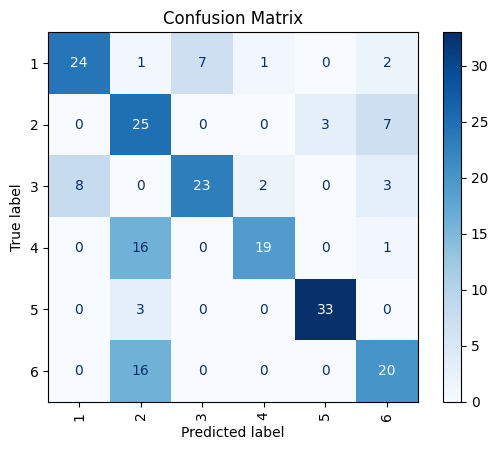

In [288]:
nb_smote = GaussianNB()
nb_smote.fit(X_smote_train_scaled, y_smote_train)
nb_smote_pred = nb_smote.predict(X_smote_test_scaled)

cv_scores = cross_val_score(nb_smote, X_smote_train_scaled, y_smote_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(nb_smote, y_smote_test, nb_smote_pred)

Random Forest

Cross-Validation mean: 0.7049605027000646
Cross-Validation std: 0.06830168132349194 

              precision    recall  f1-score   support

           1   0.972222  0.853659  0.909091        41
           2   0.692308  0.600000  0.642857        30
           3   0.500000  0.800000  0.615385         5
           4   0.000000       nan  0.000000         0
           5   0.571429  0.666667  0.615385         6
           6   0.250000  0.333333  0.285714         9

    accuracy                       0.703297        91
   macro avg   0.497660  0.650732  0.511405        91
weighted avg   0.756142  0.703297  0.724166        91



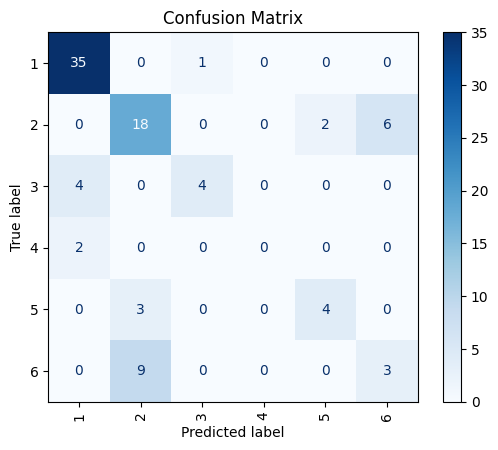

In [292]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

cv_scores = cross_val_score(rf, X_train, y_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(rf, y_test, rf_pred)

Cross-Validation mean: 0.9114728989714973
Cross-Validation std: 0.02686130595356523 

              precision    recall  f1-score   support

           1   0.885714  1.000000  0.939394        31
           2   0.857143  0.857143  0.857143        35
           3   1.000000  0.923077  0.960000        39
           4   1.000000  1.000000  1.000000        36
           5   1.000000  0.923077  0.960000        39
           6   0.861111  0.911765  0.885714        34

    accuracy                       0.934579       214
   macro avg   0.933995  0.935844  0.933709       214
weighted avg   0.938014  0.934579  0.935119       214



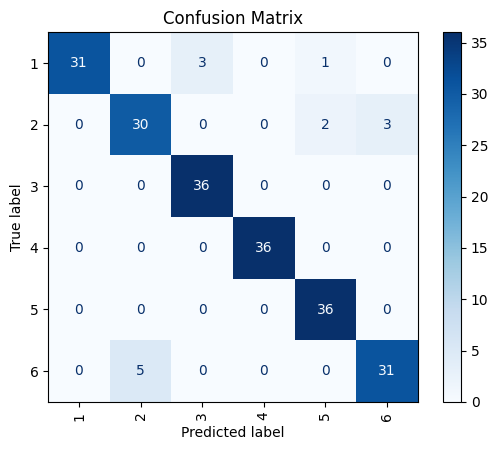

In [293]:
rf_rand = RandomForestClassifier()
rf_rand.fit(X_rand_train, y_rand_train)
rf_rand_pred = rf_rand.predict(X_rand_test)

cv_scores = cross_val_score(rf_rand, X_rand_train, y_rand_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(rf_rand, y_rand_test, rf_rand_pred)

Cross-Validation mean: 0.8591405333974791
Cross-Validation std: 0.014842958651463019 

              precision    recall  f1-score   support

           1   0.685714  0.888889  0.774194        27
           2   0.828571  0.805556  0.816901        36
           3   0.916667  0.785714  0.846154        42
           4   1.000000  0.972973  0.986301        37
           5   0.972222  0.921053  0.945946        38
           6   0.833333  0.882353  0.857143        34

    accuracy                       0.873832       214
   macro avg   0.872751  0.876090  0.871106       214
weighted avg   0.883741  0.873832  0.875851       214



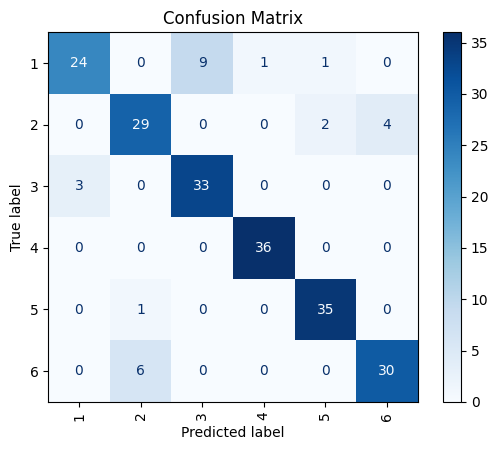

In [294]:
rf_smote = RandomForestClassifier()
rf_smote.fit(X_smote_train, y_smote_train)
rf_smote_pred = rf_smote.predict(X_smote_test)

cv_scores = cross_val_score(rf_smote, X_smote_train, y_smote_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(rf_smote, y_smote_test, rf_smote_pred)

CatBoost

Cross-Validation mean: 0.6986209720726142
Cross-Validation std: 0.04155067967835839 

              precision    recall  f1-score   support

           1   0.944444  0.871795  0.906667        39
           2   0.769231  0.645161  0.701754        31
           3   0.500000  0.800000  0.615385         5
           4   0.000000       nan  0.000000         0
           5   1.000000  0.777778  0.875000         9
           6   0.166667  0.285714  0.210526         7

    accuracy                       0.736264        91
   macro avg   0.563390  0.676090  0.551555        91
weighted avg   0.806002  0.736264  0.764176        91



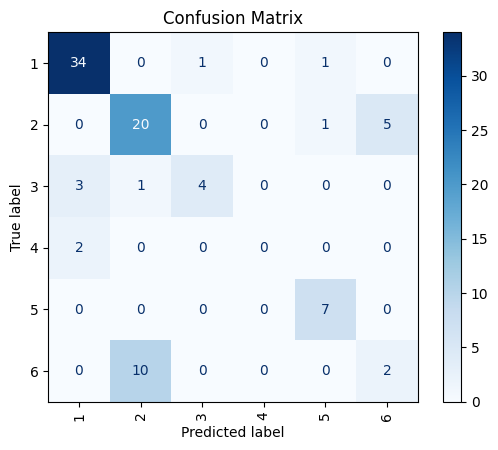

In [299]:
cb = CatBoostClassifier(verbose=False)
cb.fit(X_train, y_train)
cb_pred = cb.predict(X_test)

cv_scores = cross_val_score(cb, X_train, y_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(cb, y_test, cb_pred)

Cross-Validation mean: 0.9145773354107891
Cross-Validation std: 0.02386176478433103 

              precision    recall  f1-score   support

           1   0.828571  1.000000  0.906250        29
           2   0.857143  0.857143  0.857143        35
           3   1.000000  0.878049  0.935065        41
           4   1.000000  0.947368  0.972973        38
           5   1.000000  0.923077  0.960000        39
           6   0.805556  0.906250  0.852941        32

    accuracy                       0.915888       214
   macro avg   0.915212  0.918648  0.914062       214
weighted avg   0.924329  0.915888  0.917411       214



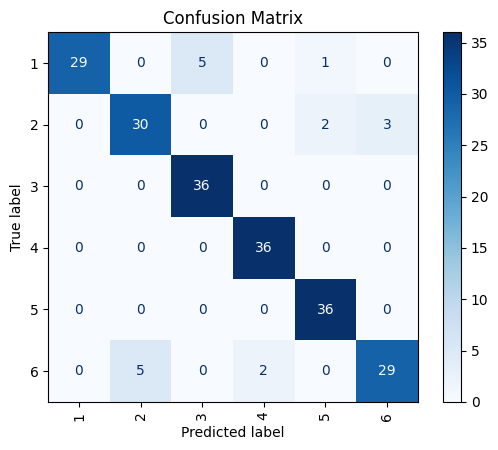

In [300]:
cb_rand = CatBoostClassifier(verbose=False)
cb_rand.fit(X_rand_train, y_rand_train)
cb_rand_pred = cb_rand.predict(X_rand_test)

cv_scores = cross_val_score(cb_rand, X_rand_train, y_rand_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(cb_rand, y_rand_test, cb_rand_pred)

Cross-Validation mean: 0.8730854203537339
Cross-Validation std: 0.02165746077023678 

              precision    recall  f1-score   support

           1   0.714286  0.925926  0.806452        27
           2   0.885714  0.794872  0.837838        39
           3   0.944444  0.829268  0.883117        41
           4   1.000000  0.947368  0.972973        38
           5   1.000000  0.923077  0.960000        39
           6   0.777778  0.933333  0.848485        30

    accuracy                       0.887850       214
   macro avg   0.887037  0.892307  0.884811       214
weighted avg   0.901328  0.887850  0.890305       214



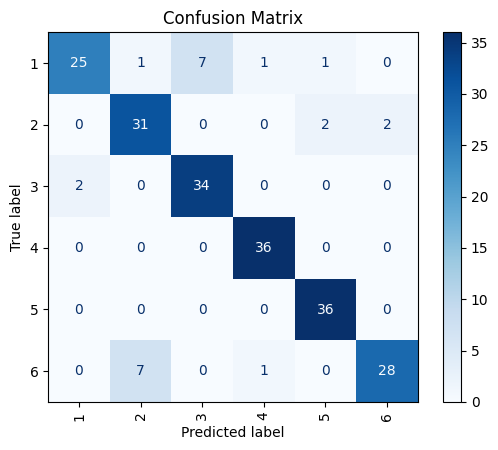

In [301]:
cb_smote = CatBoostClassifier(verbose=False)
cb_smote.fit(X_smote_train, y_smote_train)
cb_smote_pred = cb_smote.predict(X_smote_test)

cv_scores = cross_val_score(cb_smote, X_smote_train, y_smote_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(cb_smote, y_smote_test, cb_smote_pred)

LightGBM

Cross-Validation mean: 0.6978553339415587
Cross-Validation std: 0.030599763895565624 

              precision    recall  f1-score   support

           1   0.916667  0.942857  0.929577        35
           2   0.769231  0.625000  0.689655        32
           3   0.750000  0.750000  0.750000         8
           4   0.500000  1.000000  0.666667         1
           5   0.714286  0.714286  0.714286         7
           6   0.250000  0.375000  0.300000         8

    accuracy                       0.747253        91
   macro avg   0.650031  0.734524  0.675031        91
weighted avg   0.771414  0.747253  0.754625        91



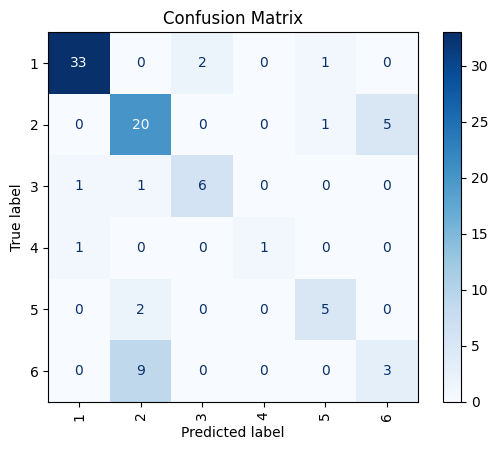

In [303]:
lgb = LGBMClassifier(verbosity=-1)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

cv_scores = cross_val_score(lgb, X_train, y_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(lgb, y_test, lgb_pred)

Cross-Validation mean: 0.9321538117056146
Cross-Validation std: 0.016584713595123837 

              precision    recall  f1-score   support

           1   0.914286  1.000000  0.955224        32
           2   0.828571  0.935484  0.878788        31
           3   1.000000  0.947368  0.972973        38
           4   1.000000  1.000000  1.000000        36
           5   1.000000  0.923077  0.960000        39
           6   0.944444  0.894737  0.918919        38

    accuracy                       0.948598       214
   macro avg   0.947884  0.950111  0.947651       214
weighted avg   0.952485  0.948598  0.949259       214



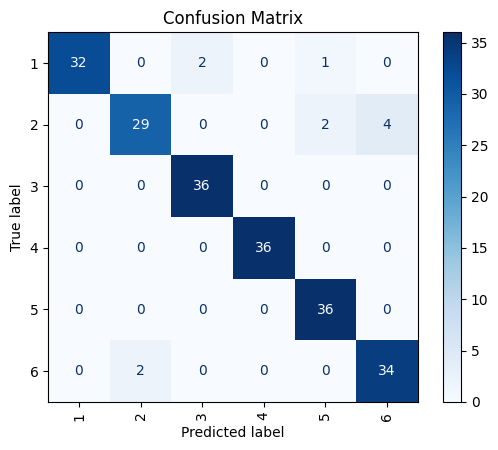

In [304]:
lgb_rand = LGBMClassifier(verbosity=-1)
lgb_rand.fit(X_rand_train, y_rand_train)
lgb_rand_pred = lgb_rand.predict(X_rand_test)

cv_scores = cross_val_score(lgb_rand, X_rand_train, y_rand_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(lgb_rand, y_rand_test, lgb_rand_pred)

Cross-Validation mean: 0.8694559579710395
Cross-Validation std: 0.016249034188828584 

              precision    recall  f1-score   support

           1   0.742857  0.896552  0.812500        29
           2   0.885714  0.861111  0.873239        36
           3   0.916667  0.846154  0.880000        39
           4   0.972222  0.945946  0.958904        37
           5   1.000000  0.923077  0.960000        39
           6   0.888889  0.941176  0.914286        34

    accuracy                       0.901869       214
   macro avg   0.901058  0.902336  0.899822       214
weighted avg   0.908285  0.901869  0.903385       214



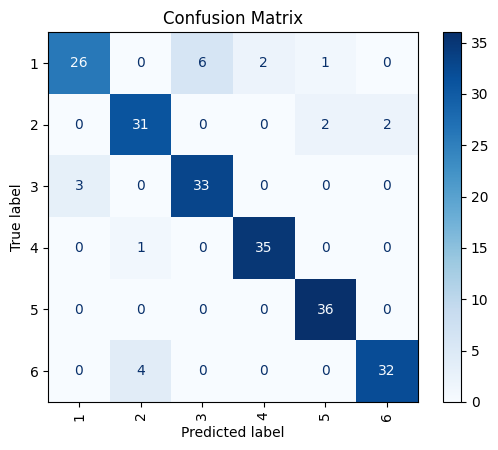

In [305]:
lgb_smote = LGBMClassifier(verbosity=-1)
lgb_smote.fit(X_smote_train, y_smote_train)
lgb_smote_pred = lgb_smote.predict(X_smote_test)

cv_scores = cross_val_score(lgb_smote, X_smote_train, y_smote_train, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(lgb_smote, y_smote_test, lgb_smote_pred)

XGBoost

Cross-Validation mean: 0.7125318068903376
Cross-Validation std: 0.02687090901526071 

              precision    recall  f1-score   support

           0   0.972222  0.921053  0.945946        38
           1   0.730769  0.612903  0.666667        31
           2   0.625000  0.833333  0.714286         6
           3   0.500000  1.000000  0.666667         1
           4   0.714286  0.833333  0.769231         6
           5   0.250000  0.333333  0.285714         9

    accuracy                       0.747253        91
   macro avg   0.632046  0.755659  0.674752        91
weighted avg   0.773451  0.747253  0.755514        91



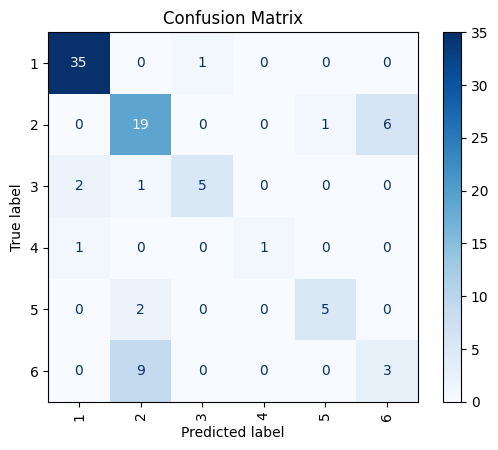

In [307]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train-1)
xgb_pred = xgb.predict(X_test)

cv_scores = cross_val_score(xgb, X_train, y_train-1, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(xgb, y_test-1, xgb_pred)

Cross-Validation mean: 0.928147554308054
Cross-Validation std: 0.015799169953699458 

              precision    recall  f1-score   support

           0   0.771429  1.000000  0.870968        27
           1   0.828571  0.906250  0.865672        32
           2   1.000000  0.837209  0.911392        43
           3   1.000000  0.972973  0.986301        37
           4   1.000000  0.947368  0.972973        38
           5   0.916667  0.891892  0.904110        37

    accuracy                       0.920561       214
   macro avg   0.919444  0.925949  0.918569       214
weighted avg   0.931119  0.920561  0.922083       214



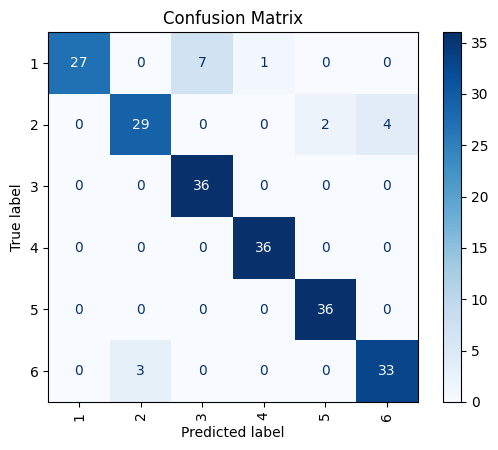

In [308]:
xgb_rand = XGBClassifier()
xgb_rand.fit(X_rand_train, y_rand_train-1)
xgb_rand_pred = xgb_rand.predict(X_rand_test)

cv_scores = cross_val_score(xgb_rand, X_rand_train, y_rand_train-1, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(xgb_rand, y_rand_test-1, xgb_rand_pred)

Cross-Validation mean: 0.8604524049671353
Cross-Validation std: 0.016236641249930035 

              precision    recall  f1-score   support

           0   0.657143  0.920000  0.766667        25
           1   0.828571  0.783784  0.805556        37
           2   0.944444  0.790698  0.860759        43
           3   0.972222  0.921053  0.945946        38
           4   0.972222  0.897436  0.933333        39
           5   0.805556  0.906250  0.852941        32

    accuracy                       0.864486       214
   macro avg   0.863360  0.869870  0.860867       214
weighted avg   0.880073  0.864486  0.867406       214



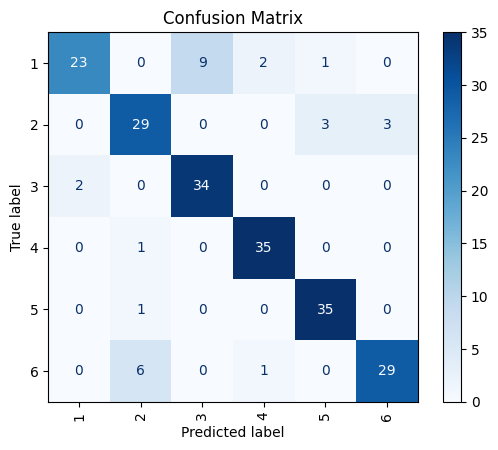

In [309]:
xgb_smote = XGBClassifier()
xgb_smote.fit(X_smote_train, y_smote_train-1)
xgb_smote_pred = xgb_smote.predict(X_smote_test)

cv_scores = cross_val_score(xgb_smote, X_smote_train, y_smote_train-1, cv=cv_fold, scoring='f1_weighted')
print("Cross-Validation mean:", cv_scores.mean())
print("Cross-Validation std:", cv_scores.std(), '\n')
model_summary(xgb_smote, y_smote_test-1, xgb_smote_pred)

## Tree Viz

In [7]:
import joblib
import lightgbm as lgb
import graphviz
import matplotlib.pyplot as plt

In [9]:
model = joblib.load('./model/lgb_rand.joblib')

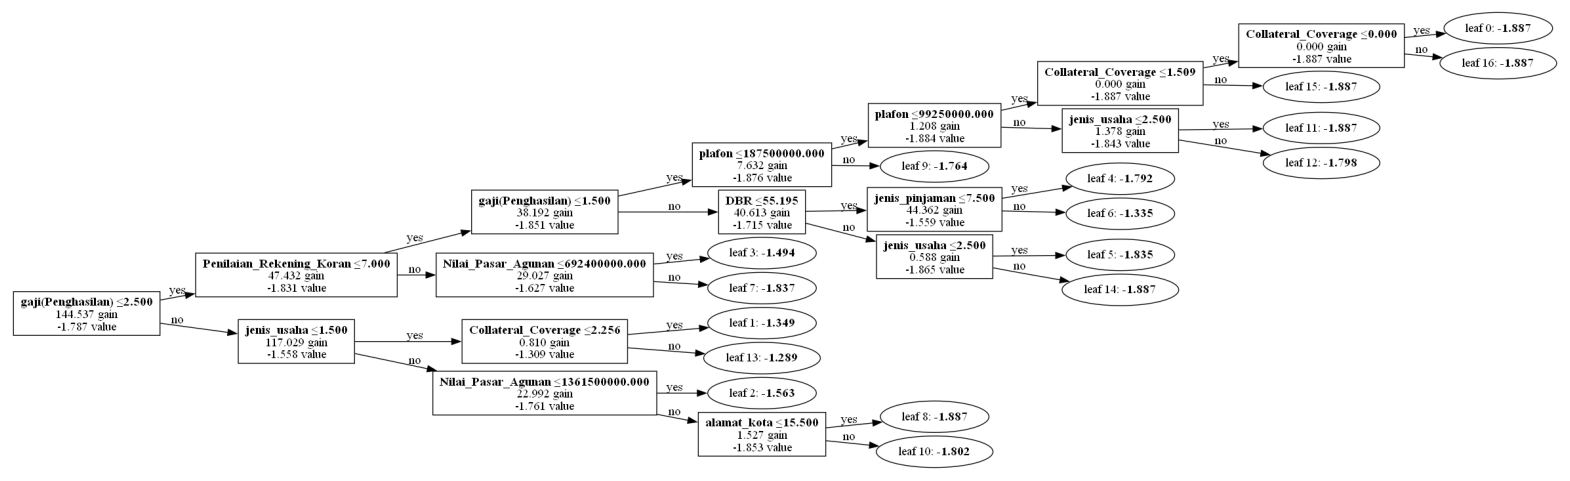

In [29]:
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value'])
plt.show()

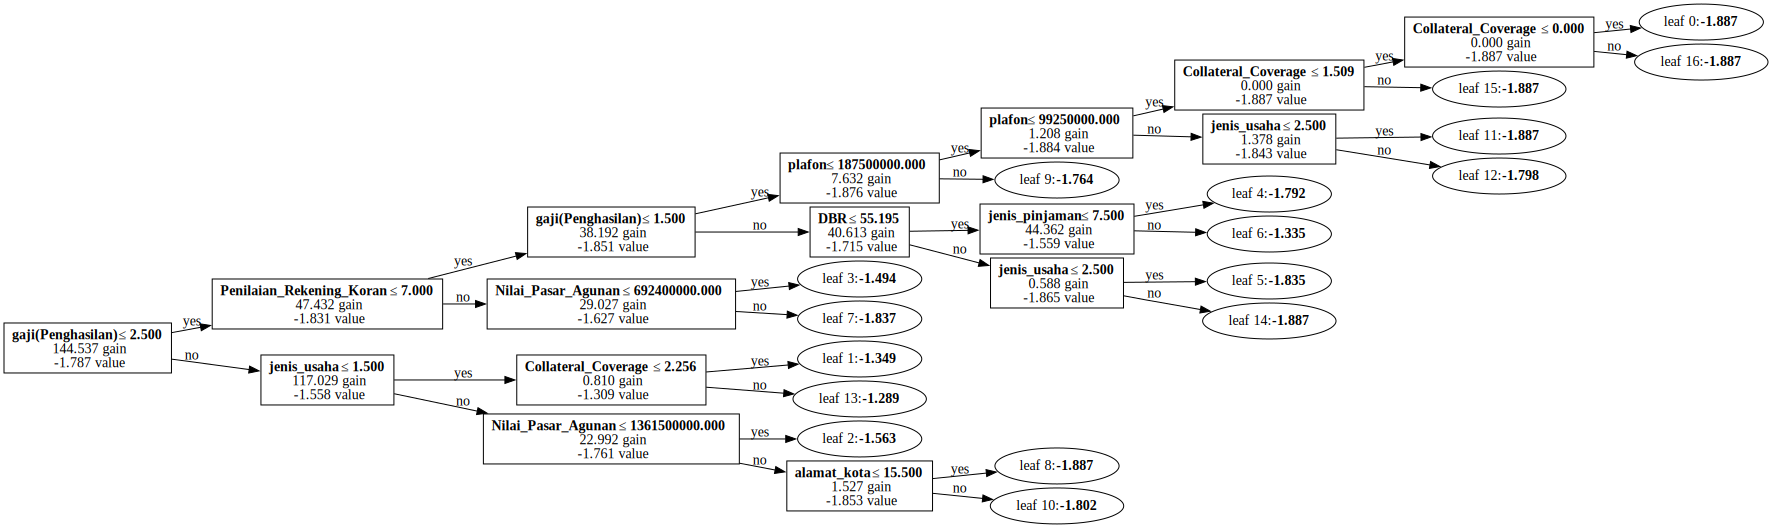

In [23]:
tree = lgb.create_tree_digraph(model, tree_index=0, show_info=['split_gain', 'internal_value'])
tree

## SHAP Value

In [117]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import shap

In [61]:
df_rand = pd.read_csv('./data/data_exist_model_rand.csv')
X_rand = df_rand.drop('risk_score', axis=1)
y_rand = df_rand['risk_score']
X_rand_train, X_rand_test, y_rand_train, y_rand_test = train_test_split(X_rand, y_rand, test_size=0.2, random_state=42, stratify=y_rand)

explainer = shap.Explainer(model, X_rand_train)

In [119]:
X = np.array([300,50,271000,0.001107011070110701,60,21,0,0,0,0,3,0,0,0,0,0])
sv = explainer(X.reshape(1, -1))

In [175]:
exp = shap.Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3], 
                  data=X.reshape(1, -1), 
                  feature_names=model.feature_name_)

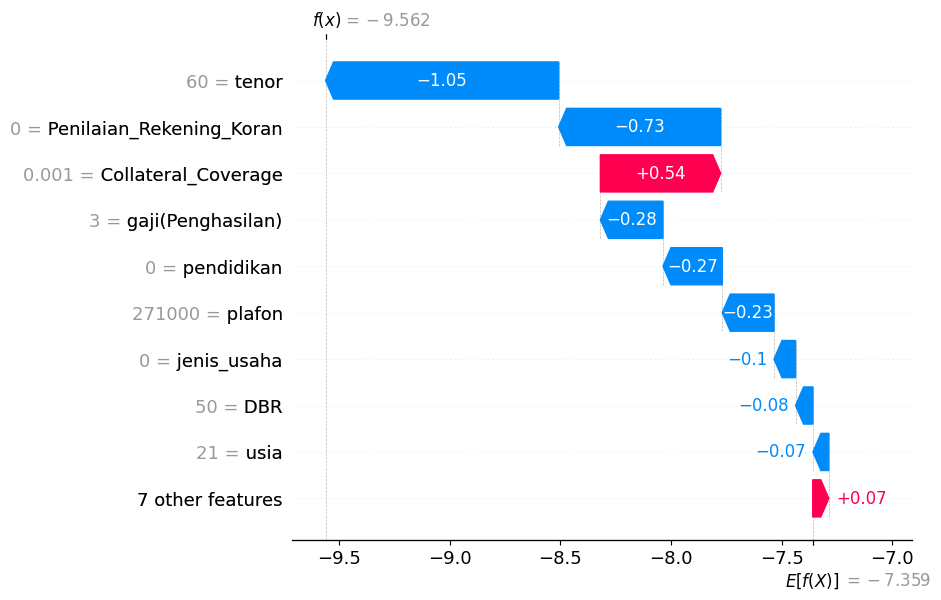

In [181]:
shap.plots.waterfall(exp[0])